## Import Library

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19, EfficientNetB0, MobileNetV2
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.regularizers import l2
import os, shutil
import warnings
from google.colab import drive
warnings.filterwarnings('ignore')

## Data

In [43]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
train_data = "/content/drive/MyDrive/Bangkit Capstone/Klasifikasi Gambar/train"
validation_data = "/content/drive/MyDrive/Bangkit Capstone/Klasifikasi Gambar/test"

In [45]:
train_gen = ImageDataGenerator( rotation_range=20,
                                zoom_range=0.15,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.15,
                                horizontal_flip=True,
                                fill_mode="nearest"
                              )

train_image_generator = train_gen.flow_from_directory(
                                            train_data,
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='categorical')


val_gen = ImageDataGenerator()
val_image_generator = val_gen.flow_from_directory(
                                            validation_data,
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='categorical')

Found 408 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


In [46]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [77]:
learning_rate = 0.001

model = tf.keras.models.Sequential([
      base_model,
      Flatten(),
      Dense(512, activation='relu'),
      BatchNormalization(),
      Dropout(0.5),
      Dense(256, activation='relu'),
      BatchNormalization(),
      Dropout(0.5),
      Dense(4, activation='softmax')
      ])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [78]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_8 (Flatten)         (None, 25088)             0         
                                                                 
 dense_30 (Dense)            (None, 512)               12845568  
                                                                 
 batch_normalization_16 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dropout_18 (Dropout)        (None, 512)               0         
                                                                 
 dense_31 (Dense)            (None, 256)               131328    
                                                      

In [79]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90 and logs.get('val_accuracy')>0.90):
      print("accuracy > 99% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [80]:
checkpoint = keras.callbacks.ModelCheckpoint(
             'model_best.h5',
             save_best_only=True,
             monitor='val_accuracy',
             mode='max')

early_stopping = keras.callbacks.EarlyStopping(patience=10,monitor='val_loss',restore_best_weights=True)

In [81]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [82]:
history = model.fit(train_image_generator,
                    validation_data=val_image_generator,
                    epochs=50,
                    callbacks=[callbacks, checkpoint])

Epoch 1/50
13/13 [==============================] - 12s 770ms/step - loss: 1.2822 - accuracy: 0.5711 - val_loss: 1.6536 - val_accuracy: 0.7625
Epoch 2/50
13/13 [==============================] - 9s 687ms/step - loss: 0.6584 - accuracy: 0.7623 - val_loss: 1.3686 - val_accuracy: 0.7875
Epoch 3/50
13/13 [==============================] - 9s 678ms/step - loss: 0.4701 - accuracy: 0.8382 - val_loss: 0.7940 - val_accuracy: 0.8125
Epoch 4/50
13/13 [==============================] - 11s 841ms/step - loss: 0.4341 - accuracy: 0.8431 - val_loss: 0.5527 - val_accuracy: 0.8250
Epoch 5/50
13/13 [==============================] - 10s 777ms/step - loss: 0.3108 - accuracy: 0.8824 - val_loss: 0.5868 - val_accuracy: 0.8500
Epoch 6/50
13/13 [==============================] - 10s 716ms/step - loss: 0.2829 - accuracy: 0.9020 - val_loss: 0.6074 - val_accuracy: 0.8625
Epoch 7/50
13/13 [==============================] - 11s 801ms/step - loss: 0.2452 - accuracy: 0.9167 - val_loss: 0.3939 - val_accuracy: 0.8875
E

In [83]:
model.evaluate(train_image_generator)

13/13 [==============================] - 9s 642ms/step - loss: 0.0288 - accuracy: 0.9902


[0.02879195660352707, 0.9901960492134094]

In [84]:
model.evaluate(val_image_generator)

3/3 [==============================] - 1s 127ms/step - loss: 0.3599 - accuracy: 0.9125


[0.35991260409355164, 0.9125000238418579]

<Axes: >

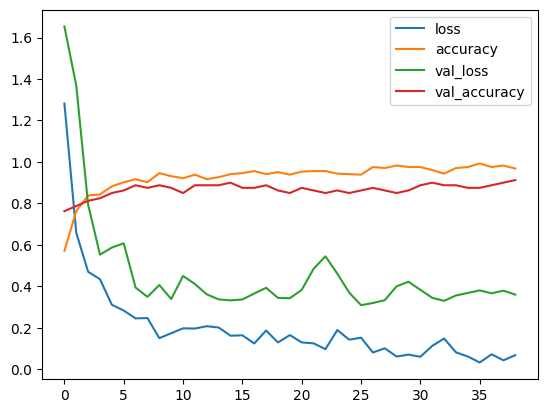

In [85]:
pd.DataFrame(history.history).plot()

In [86]:
class_indices = train_image_generator.class_indices
class_indices

{'Bukan Makanan': 0, 'Kasar': 1, 'Lumat': 2, 'Lunak': 3}

In [101]:
from tensorflow.keras.preprocessing import image
from google.colab import files

# Load the best saved model
model = tf.keras.models.load_model('model_best.h5')

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    """
    Load an image and preprocess it to be suitable for the model.
    """
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims to add batch size
    img_array = tf.keras.applications.vgg19.preprocess_input(img_array)  # Preprocess image for VGG19
    return img_array

def predict_image(img_path):
    """
    Predict the class of an image.
    """
    # Preprocess the image
    img_array = load_and_preprocess_image(img_path)

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)

    # Get the class labels from the training data generator
    class_labels = list(train_image_generator.class_indices.keys())

    # Map predicted class index to class label
    predicted_label = class_labels[predicted_class[0]]

    return predicted_label

# Upload the file
uploaded = files.upload()

# Predict the uploaded image
for img_name in uploaded.keys():
    predicted_label = predict_image(img_name)
    print(f"The predicted label for the image '{img_name}' is: {predicted_label}")


Saving bubur_candil.jpeg to bubur_candil.jpeg
1/1 [==============================] - 0s 187ms/step
The predicted label for the image 'bubur_candil.jpeg' is: Lunak


In [94]:
model_json = model.to_json()
with open("model_best.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights to a separate .h5 file
model.save_weights("model_best_weights.h5")

In [97]:
model.save("./model/model_texture.h5")

In [99]:
!tensorflowjs_converter --input_format=keras {"./model/model_texture.h5"} ./model

2024-06-01 08:51:22.525949: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [100]:
import zipfile
import os

def create_zip_folder(folder_path, zip_path):
    """
    Membuat file zip dari folder.

    Args:
    - folder_path (str): Path folder yang ingin Anda zip.
    - zip_path (str): Path di mana file zip akan disimpan.
    """
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

folder_path = '/content/model'
zip_path = '/content/model.zip'

create_zip_folder(folder_path, zip_path)
print(f"Folder '{folder_path}' telah di-zip ke '{zip_path}'.")


Folder '/content/model' telah di-zip ke '/content/model.zip'.
